In [1]:
import  numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

In [2]:
import warnings
# 忽视来自torch.nn.functional的特定警告
warnings.filterwarnings("ignore")
import sys
#将上级目录作为根目录，这样就可以直接import data_loader等
sys.path.append('..')
from model.cen_qb import CEN_QB
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
def mean_squared_error(true_values, estimated_values):
    return np.mean((true_values.flatten() - estimated_values.flatten()) ** 2)

In [4]:
class EarlyStopping:
    def __init__(self, patience=30, verbose=False,delta=0.001):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 3
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss, model,filename='best_model.pth'):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model,filename)
        elif score < self.best_score + self.delta:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                if self.verbose:
                    print("Early stopping")
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model,filename)
            self.epochs_no_improve = 0

    def save_checkpoint(self, model,filename):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased. Saving model')
        torch.save(model.state_dict(),filename)

In [5]:
data=pd.read_csv('../data/实证/processed_data_reversed.csv')
data=data.iloc[:,3:]
data=data.drop(columns=['Q15'])

In [6]:
data.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q50
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


In [7]:
data.shape

(4474, 49)

In [8]:
pandas2ri.activate()
r_data = pandas2ri.py2rpy(data)
# 加载 R 代码
r_code = """
library(mirt)

# 将数据转换为 mirt 包的格式
data_matrix <- as.matrix(data_df)

# 拟合2参数IRT模型
model <- mirt(data_matrix, 1, itemtype = '2PL')

# 获取项目参数（区分度和难度）
item_params <- coef(model, IRTpars = TRUE, simplify = TRUE)

# 提取 a 和 b 参数
a_params <- item_params$items[, 1]
b_params <- item_params$items[, 2]

# 获取被试的能力参数
abilities <- fscores(model)

list(a_params = a_params, b_params = b_params, abilities = abilities)
"""

# 在 R 中运行代码
r_globals = robjects.globalenv
r_globals['data_df'] = r_data
result = robjects.r(r_code)

# 获取结果
a_params = np.array(result.rx2('a_params'))
b_params = np.array(result.rx2('b_params'))
abilities = np.array(result.rx2('abilities')).flatten()

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: lattice



Iteration: 67, Log-Lik: -114658.919, Max-Change: 0.00006


In [9]:
a_params

array([0.75000301, 0.83498844, 0.53259139, 0.85181293, 0.609033  ,
       1.09423345, 0.81953197, 0.83676573, 0.46010758, 0.64105106,
       1.98986994, 0.63653307, 0.80317123, 0.94150523, 0.64128826,
       0.87667421, 0.87647155, 0.43792475, 0.42414907, 0.94613641,
       1.16093123, 0.95704079, 0.92716916, 1.24364107, 1.13097812,
       2.93717152, 2.02533393, 1.31451671, 0.93701813, 2.22975514,
       1.43109476, 1.25395447, 0.97142372, 0.72575409, 1.95947455,
       1.77739798, 1.20184738, 1.18539003, 1.76187247, 1.19586721,
       1.2488203 , 1.39133056, 0.77164226, 1.66902887, 2.076815  ,
       1.71308718, 2.21428523, 1.57820706, 1.42289602])

In [10]:
b_params

array([-0.96429274,  0.61737237, -1.63801707,  0.09864452, -1.18831292,
       -1.48670588, -1.51569376,  0.62408643,  0.3403995 , -0.24088293,
       -1.35758101, -0.78547903,  1.24656899,  0.80000307, -0.22090504,
       -0.67481586, -1.36558197,  0.64725027,  0.62179166,  0.14347012,
       -1.38632611, -0.3729968 , -0.3182046 , -0.71987758, -1.48994878,
       -1.49243411, -1.2732238 , -0.54530359, -0.19479598, -1.04865675,
       -0.60731901, -0.9652635 , -0.19508489, -1.29852885, -1.28054664,
       -1.60876459, -1.40168937, -0.54953268, -1.1270652 , -0.8495768 ,
       -1.84245186, -1.30023061, -0.50916119, -0.59945438, -0.7037015 ,
       -0.77562566, -0.8421408 , -0.4830899 , -1.68740762])

In [10]:
n_item = data.shape[1]
n_person = data.shape[0]
res_mat=torch.from_numpy(data.values).float()
depth=5
activation='tanh'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr=0.0001
early_stopping_count=30
epochs=5000

In [11]:
model=CEN_QB(n_item,n_person,depth,activation).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()
early_stopping = EarlyStopping(patience=early_stopping_count, verbose=False)
for epoch in range(epochs):
    res_mat = res_mat.clone().to(device)
    res_mat_item = res_mat.clone().T.to(device)
    label = res_mat.flatten().to(device)
    model.train()
    optimizer.zero_grad()
    pred = model(res_mat, res_mat_item).flatten()
    loss = loss_fn(pred, label)
    loss.backward()
    optimizer.step()
    loss_value=loss.item()
    early_stopping(loss_value, model)
    

In [12]:
model.load_state_dict(torch.load('best_model.pth'))
z=model.person_net(res_mat).cpu().detach().numpy().flatten()
a,b=model.item_net(res_mat_item)
a=a.cpu().detach().numpy().flatten()
b=b.cpu().detach().numpy().flatten()

In [13]:
b

array([-0.9294565 ,  0.57636243, -1.5966182 ,  0.09420068, -1.1546054 ,
       -1.4558663 , -1.470963  ,  0.5773483 ,  0.31691325, -0.22802326,
       -1.3509654 , -0.73952585,  1.1364286 ,  0.73761666, -0.20494495,
       -0.64184594, -1.3211046 ,  0.6197749 ,  0.5935355 ,  0.13634036,
       -1.3597102 , -0.3510999 , -0.3001352 , -0.6947282 , -1.4623051 ,
       -1.571747  , -1.2644024 , -0.52618766, -0.18274392, -1.0444252 ,
       -0.5867896 , -0.9433911 , -0.18258399, -1.2538173 , -1.2702107 ,
       -1.5971979 , -1.382957  , -0.52871263, -1.1127963 , -0.82476836,
       -1.8304163 , -1.2825294 , -0.48924786, -0.5823757 , -0.6890669 ,
       -0.7574769 , -0.8317453 , -0.46557176, -1.6648021 ], dtype=float32)

In [14]:
b_params

array([-0.96429274,  0.61737237, -1.63801707,  0.09864452, -1.18831292,
       -1.48670588, -1.51569376,  0.62408643,  0.3403995 , -0.24088293,
       -1.35758101, -0.78547903,  1.24656899,  0.80000307, -0.22090504,
       -0.67481586, -1.36558197,  0.64725027,  0.62179166,  0.14347012,
       -1.38632611, -0.3729968 , -0.3182046 , -0.71987758, -1.48994878,
       -1.49243411, -1.2732238 , -0.54530359, -0.19479598, -1.04865675,
       -0.60731901, -0.9652635 , -0.19508489, -1.29852885, -1.28054664,
       -1.60876459, -1.40168937, -0.54953268, -1.1270652 , -0.8495768 ,
       -1.84245186, -1.30023061, -0.50916119, -0.59945438, -0.7037015 ,
       -0.77562566, -0.8421408 , -0.4830899 , -1.68740762])

In [15]:
b-b_params

array([ 0.03483627, -0.04100994,  0.04139889, -0.00444384,  0.03370753,
        0.03083954,  0.04473076, -0.04673814, -0.02348625,  0.01285967,
        0.00661563,  0.04595317, -0.1101404 , -0.06238641,  0.01596009,
        0.03296992,  0.04447732, -0.0274754 , -0.02825618, -0.00712976,
        0.0266159 ,  0.02189689,  0.01806941,  0.02514938,  0.02764371,
       -0.07931284,  0.00882141,  0.01911593,  0.01205206,  0.0042315 ,
        0.0205294 ,  0.02187241,  0.0125009 ,  0.04471153,  0.0103359 ,
        0.0115667 ,  0.01873239,  0.02082005,  0.0142689 ,  0.02480844,
        0.01203553,  0.01770125,  0.01991334,  0.01707868,  0.01463461,
        0.01814874,  0.01039547,  0.01751814,  0.02260554])

In [16]:
np.corrcoef(a_params, a)[0, 1]

0.9920404632414043

In [17]:
np.corrcoef(b_params, b)[0, 1]

0.9994619993893855

In [18]:
np.corrcoef(abilities, z)[0, 1]

0.9956803251342584

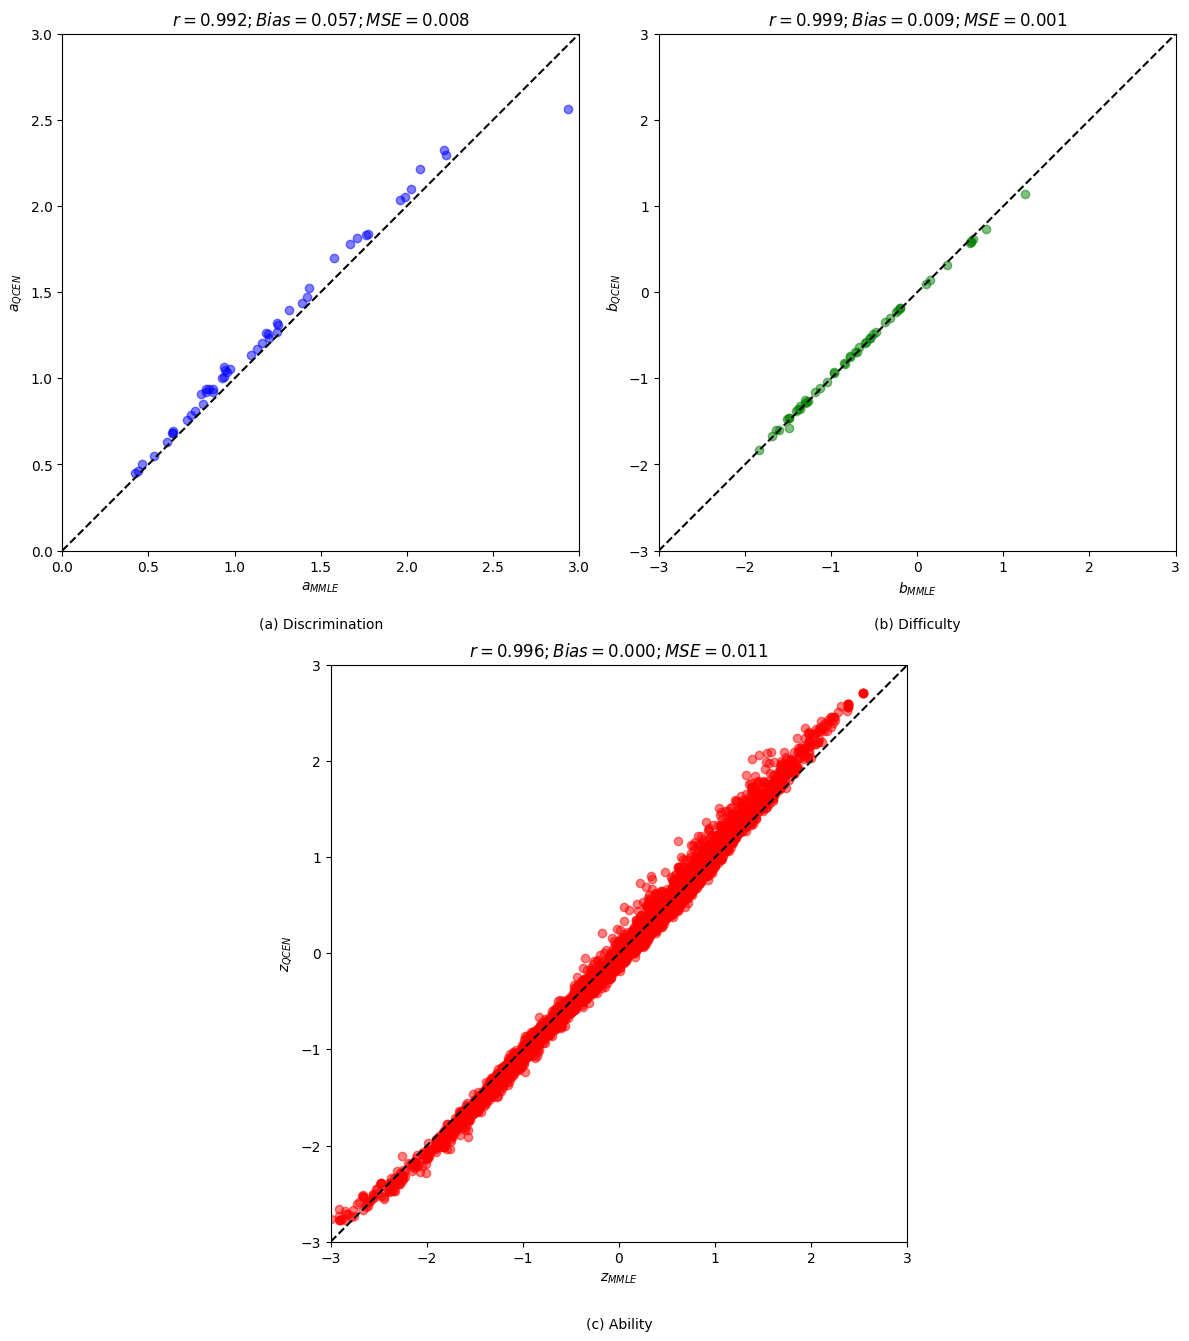

In [20]:
# 计算每个参数的 MSE 和偏差
mse_a = mean_squared_error(a_params, a)
mse_b = mean_squared_error(b_params, b)
mse_theta = mean_squared_error(abilities,z)

bias_a = np.mean( a- a_params)
bias_b = np.mean(b - b_params)
bias_theta = np.mean(z - abilities)

correlation_a = np.corrcoef(a_params, a)[0, 1]
correlation_b = np.corrcoef(b_params, b)[0, 1]
correlation_theta = np.corrcoef(abilities,z)[0, 1]

# 创建图形
fig = plt.figure(figsize=(12, 14))
# 区分度 (a 参数)
ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(a_params, a, c='blue', alpha=0.5)
ax1.plot([0, 3], [0, 3], 'k--')
ax1.set_xlim(0, 3)
ax1.set_ylim(0, 3)
ax1.set_xlabel(r'$a_{MMLE}$')
ax1.set_ylabel(r'$a_{QCEN}$')
ax1.set_aspect('equal', adjustable='box')
ax1.set_title(f'$r = {correlation_a:.3f}; Bias = {bias_a:.3f}; MSE = {mse_a:.3f}$')
ax1.text(0.5, -0.15, '(a) Discrimination', ha='center', transform=ax1.transAxes)

# 难度 (b 参数)
ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(b_params, b, c='green', alpha=0.5)
ax2.plot([-3, 3], [-3, 3], 'k--')
ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)
ax2.set_xlabel(r'$b_{MMLE}$')
ax2.set_ylabel(r'$b_{QCEN}$')
ax2.set_aspect('equal', adjustable='box')
ax2.set_title(f'$r = {correlation_b:.3f}; Bias = {bias_b:.3f}; MSE = {mse_b:.3f}$')
ax2.text(0.5, -0.15, '(b) Difficulty', ha='center', transform=ax2.transAxes)

# 能力参数 (theta)
ax3 = fig.add_subplot(2, 1, 2)
ax3.scatter(abilities, z, c='red', alpha=0.5)
ax3.plot([-3, 3], [-3, 3], 'k--')
ax3.set_xlim(-3, 3)
ax3.set_ylim(-3, 3)
ax3.set_xlabel(r'$z_{MMLE}$')
ax3.set_ylabel(r'$z_{QCEN}$')
ax3.set_aspect('equal', adjustable='box')
ax3.set_title(f'$r = {correlation_theta:.3f}; Bias = {bias_theta:.3f}; MSE = {mse_theta:.3f}$')
ax3.text(0.5, -0.15, '(c) Ability', ha='center', transform=ax3.transAxes)

# 调整布局，增加上下子图之间的间距
plt.tight_layout(rect=[0, 0.04, 1, 1], h_pad=2)
plt.savefig('实证研究.png')
plt.show()